# Training the generative network

which predicts CEM design parameters from text inputs

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [46]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import json

plt.rcParams['svg.fonttype'] = 'none'

version of the libraries

In [43]:
tf.__version__

'2.8.2'

In [44]:
np.__version__

'1.22.3'

In [47]:
matplotlib.__version__

'3.4.3'

In [4]:
import dataset
import npyzip

import cem_mini
from cem_mini import plot_cem_form

plotting function of CEM forms

In [5]:
import math

def _check_form(form,ax,view, thickness_base=0.5, thickness_ratio=0.02):
    plot_cem_form(ax,form['coords'],form['edges'],form['forces'],view=view,thickness_base=thickness_base,thickness_ratio=thickness_ratio)

def check_forms(forms,axis='off',view='3D-45',titles=None, title_offset=None, rows=None, suptitle=None, figsize=None, fname=None):
    if type(forms) is list:
        if rows is None:
            rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        if figsize is None:
            figsize=8
            
        fig=plt.figure(figsize=(figsize,int(figsize/cols*rows)))
        
        show_title=type(titles) is list
        
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form(forms[i],ax,view, thickness_base=0.2, thickness_ratio=0.01)
            plt.axis(axis)
            if show_title:
                plt.title(titles[i],y=title_offset)
        if suptitle is not None:
            plt.suptitle(suptitle)
        
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(figsize,figsize))
        ax=plt.axes(projection='3d')
        _check_form(forms,ax,view)
        plt.axis(axis)
        if type(titles) is str:
            plt.title(titles,y=title_offset)
        if suptitle is not None:
            plt.suptitle(suptitle)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

load the cem dataset

In [11]:
cem_dataset=dataset.get_dataset_from_file(r'..\cem-dataset\cem-towers\SDML_CEM.py')

### CEM generator for tower dataset

adding additional indexing information to the dataset<br>
(i.e., which column of the CSV file corresponds to which floor / trail edges etc.)

In [7]:
# for tower dataset only
# add feature names which get node_xyz by floors
floor_num=10
node_per_floor=16
dev_edge_per_floor=24

trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()

In [8]:
trail_length_per_path=[[cem_dataset.name_dict['trail_length'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]
trail_mag_per_path=[[cem_dataset.name_dict['trail_mag'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]

node_x_per_path=[[cem_dataset.name_dict['node_x'][i] for i in t] for t in trail_path]
node_y_per_path=[[cem_dataset.name_dict['node_y'][i] for i in t] for t in trail_path]
node_z_per_path=[[cem_dataset.name_dict['node_z'][i] for i in t] for t in trail_path]

node_x_by_floor=[cem_dataset.name_dict['node_x'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_y_by_floor=[cem_dataset.name_dict['node_y'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_z_by_floor=[cem_dataset.name_dict['node_z'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]

dev_mag_by_floor=[cem_dataset.name_dict['dev_mag'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]
dev_length_by_floor=[cem_dataset.name_dict['dev_length'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]

In [9]:
for i in range(floor_num+1):
    cem_dataset.name_dict['node_x_%d'%i]=node_x_by_floor[i]
    cem_dataset.name_dict['node_y_%d'%i]=node_y_by_floor[i]
    cem_dataset.name_dict['node_z_%d'%i]=node_z_by_floor[i]

for i in range(floor_num):
    cem_dataset.name_dict['dev_length_%d'%i]=dev_length_by_floor[i]
    cem_dataset.name_dict['dev_mag_%d'%i]=dev_mag_by_floor[i]

for i in range(node_per_floor):
    cem_dataset.name_dict['trail_length_%d'%i]=trail_length_per_path[i]
    cem_dataset.name_dict['trail_mag_%d'%i]=trail_mag_per_path[i]
    cem_dataset.name_dict['node_x_trail-%d'%i]=node_x_per_path[i]
    cem_dataset.name_dict['node_y_trail-%d'%i]=node_y_per_path[i]
    cem_dataset.name_dict['node_z_trail-%d'%i]=node_z_per_path[i]

In [10]:
x0_sample = cem_dataset.get_vector(0,'node_x_0')
x0_sample = x0_sample/x0_sample.max()

y0_sample = cem_dataset.get_vector(0,'node_y_0')
y0_sample = y0_sample/y0_sample.max()

def generate_node_xy(x_size,y_size,grid=3):
    '''
    generate the node_x_0 and node_y_0 from the input grid sizes
    
    this function will be used when varifying the generated input parameters
    '''
    return  x0_sample*grid*x_size, y0_sample*grid*y_size

def to_cem_mini_topology(trail_length_raw, deviation_mag_raw, node_x_raw, node_y_raw, node_z_raw, load_x=0, load_y=0, load_z=-10):
    '''
    a validation function which generate the form of SDML-CEM dataset, using CEM input parameters from the dataset
    
    the function should produce identical form as shown in the dataset
    
    this function can later be extended as the python-version generator to validat the input parameters proposed by the Text2Form engine
    '''
    # compute trail path (i.e., connect trail edges / segments to continuous path)
    trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()
    
    # assign trail length (with positive and negative signs)
#     trail_length_raw=cem_dataset.get_vector(which,'trail_length')
#     trail_mag_raw=np.sign(cem_dataset.get_vector(which,'trail_mag'))

    trail_mag_raw=np.full(trail_length_raw.shape,-1)

    trail_length=[[trail_length_raw[to_trail_edge_indice(i,j)] * trail_mag_raw[to_trail_edge_indice(i,j)] for j in range(len(trail_path[i])-1)] for i in range(len(trail_path))]
    
    # assign deviation force magnitudes (with positive and negative signs)
    deviation_mag=list(deviation_mag_raw) # list(cem_dataset.get_vector(which,'dev_mag'))
    
    # assign initial node positions
    node_xyz=np.asarray([node_x_raw, node_y_raw, node_z_raw]).T
    node_xyz={i:list(node_xyz[i]) for i in range(len(node_xyz))}
    
    # assign loads (uniform load on all nodes)
    load_xyz=[load_x,load_y,load_z]
    load_xyz={i:load_xyz for i in range(cem_dataset.node_num)}

    # generate the topology using cem-mini generator
    # note that: the CEM input parameters by SDML-CEM dataset has already been optimized
    # therefore, idential form should be obtained without the need of optimization process
    T=cem_mini.create_topology(cem_dataset.node_num)
    cem_mini.set_trail_paths(T, trail_path,trail_length)
    cem_mini.set_deviation_edges(T,deviation_edge,deviation_mag)
    cem_mini.set_original_node_positions(T,node_xyz)
    cem_mini.set_node_loads(T,load_xyz)

    # solve the CEM
    F, Fc= cem_mini.CEM(T,1e-6)
    F['forces']=F['edge_forces']
    
    return F, Fc

## load text labels

In [12]:
user_name='guo-12x12'

label_weight_file=r'..\outputs\labels\%s-labels-vector.npy'%user_name
label_word_file=r'..\outputs\labels\%s-labels-vector-channel.csv'%user_name

label_weights = np.load(label_weight_file)

with open(label_word_file) as f:
    label_words = f.read().split(',')

print(label_words, label_weights.shape)

['balanced', 'heavy', 'iconic', 'simple', 'thick', 'thin', 'twisted', 'unbalanced'] (4727, 8)


## load word2vec model and the reference words

currently this part is neglected for simplicity (dummy dataset has only 5 labeling keywords)<br>
i.e., using label_weights rather than label_encoding_vectors

In [13]:
# NLP word embedding model
from glove_models import GloVe
glove=GloVe('..\\GloVe300')

4767006


In [14]:
glove("hello world world").shape

(3, 300)

In [15]:
import BoW_encoding as bow

In [16]:
label_vectors = glove(' '.join(label_words))

# encoding methods used by my PhD, have similar performances
# input_vect_encoder=bow.high_level_encoding(label_vectors,
#                             bow.mid_level_coding(bow.inverse_euclidean_p1, None,bow.magnitude_normalizer()),# BoW.minmax_normalizer(8)),
#                             bow.pooling_mean)

input_vect_encoder=bow.high_level_encoding(label_vectors,
                                           bow.mid_level_coding(bow.inverse_euclidean_p1, None, bow.prob_normalizer(8)),# BoW.minmax_normalizer(8)),
                                           bow.pooling_mean)

input_text_encoder = lambda x: input_vect_encoder(glove(x))

In [17]:
input_text_encoder("strange geometry with strong feeling of heavy mass")

array([0.09435418, 0.25226954, 0.09855674, 0.22819853, 0.07049102,
       0.07641538, 0.10185239, 0.0778622 ], dtype=float32)

## conditional GAN model

reference: https://github.com/wtliao/text2image<br>
reference: https://keras.io/examples/generative/conditional_gan/

### 1. training data (which determines the dimension of the inputs)

In [18]:
dense_features=['grid_size_x','grid_size_y']
cnn_features=['trail_length','dev_mag']

vector_features = dense_features + cnn_features

all_vectors_raw=cem_dataset.get_vector(range(cem_dataset.get_num_samples()), vector_features)

all_vectors_mean=all_vectors_raw.mean(axis=0)
all_vectors_std=all_vectors_raw.std(axis=0)

all_vectors = (all_vectors_raw-all_vectors_mean) / all_vectors_std
all_vectors.shape

(4727, 402)

In [19]:
all_labels = label_weights # use 5-dim label vectors
# all_labels = label_encoding_vectors # use 68-dim word-embeding vectors

In [20]:
# dense_features=['grid_size_x','grid_size_y']
# cnn_features=['trail_length','dev_mag']

# vector parts that will be processed using dense layers
dense_size=sum([len(cem_dataset.name_dict[k]) for k in dense_features])
# vector parts that will be processed using CONV layers
cnn_branch_size=[len(cem_dataset.name_dict[k]) for k in cnn_features]
# total size of CONV vector parts
cnn_size=sum([len(cem_dataset.name_dict[k]) for k in cnn_features])

print([dense_size,cnn_size],cnn_branch_size)

[2, 400] [160, 240]


In [21]:
# computing the latent space size
layer_stacks=2
upsampling_size=2
size_reduce_factor=upsampling_size**layer_stacks
input_size_branch_latent=[s//size_reduce_factor for s in cnn_branch_size]
input_size_branch_latent

[40, 60]

In [22]:
# computing the input size of generator and discriminator
input_size_text=all_labels.shape[-1] #len(dataset.SELECTED_KEYWORDS)
input_size_latent=sum(input_size_branch_latent)+dense_size

input_size_generator=input_size_latent+input_size_text
input_size_discriminator=dense_size+cnn_size+input_size_text

generate_vector_size=dense_size+cnn_size

print(input_size_generator,input_size_discriminator, generate_vector_size)

110 410 402


### 2A. build generator and discriminator

In [23]:
class SliceLayer(keras.layers.Layer):
    def __init__(self, begin, size,**kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.begin = begin
        self.size = size
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'begin': self.begin,
            'size': self.size,
        })
        return config
    def call(self, inputs):
        return tf.slice(inputs, self.begin, self.size)

In [24]:
def split_op(in_layer, sizes):
    '''
    split the input layer
    '''
    branches=[SliceLayer(begin=[0,sum(sizes[:i])], size=[-1, sizes[i]])(in_layer) for i in range(len(sizes))]
    return branches

In [25]:
def upsamplings(layer, stacks, linear=True, flatten=True):
    for i in range(stacks):
        layer=keras.layers.Conv1DTranspose(8*(2**i), 3, strides=2, padding="same")(layer)
        layer=keras.layers.LeakyReLU(alpha=0.1)(layer)
        
        layer=keras.layers.Conv1D(8*(2**i), 7, padding="same")(layer) # a linear layer
        layer=keras.layers.LeakyReLU(alpha=0.1)(layer)
        layer=keras.layers.Conv1D(8*(2**i), 7, padding="same")(layer) # a linear layer
        layer=keras.layers.LeakyReLU(alpha=0.1)(layer)
    
    if linear:
        layer = keras.layers.Conv1D(1, 7, padding="same")(layer) # a linear layer
        if flatten:
            layer = keras.layers.Flatten()(layer)
            
    return layer

In [26]:
def conv(layer, stacks):
    for i in range(stacks):
        layer=keras.layers.Conv1D(8*(2**i), 7, padding="same")(layer)
        layer=keras.layers.LeakyReLU(alpha=0.1)(layer)
        layer=keras.layers.MaxPool1D(2,2)(layer)
        
    layer = keras.layers.GlobalMaxPooling1D()(layer) # a linear layer
#     layer = keras.layers.Flatten()(layer)
    return layer

generator

Full dense generator works, Conv generator not working well

In [27]:
ly_gen_in=keras.layers.Input((input_size_generator,))

ly_gen=keras.layers.Dense(128)(ly_gen_in) 
ly_gen=keras.layers.LeakyReLU(alpha=0.1)(ly_gen)

ly_gen=keras.layers.Dense(256)(ly_gen_in) 
ly_gen=keras.layers.LeakyReLU(alpha=0.1)(ly_gen) 

ly_gen_out=keras.layers.Dense(generate_vector_size)(ly_gen)

print(ly_gen_out)
# Create the generator.
generator = keras.models.Model(inputs=ly_gen_in, outputs=ly_gen_out,name='generator')
generator.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 402), dtype=tf.float32, name=None), name='dense_2/BiasAdd:0', description="created by layer 'dense_2'")
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 110)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               28416     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 402)               103314    
                                                                 
Total params: 131,730
Trainable params: 131,730
Non-trainable params: 0
_________________________________________________________________


In [28]:
# ly_gen_in=keras.layers.Input((input_size_generator,)) # 5 and 10 + 15 + 2

# ly_gen_latent, ly_gen_labels = split_op(ly_gen_in, [input_size_latent, input_size_text]) # 2 and 10+15

# # 2 dense layers for the text
# ly_gen_labels=keras.layers.Dense(128)(ly_gen_labels)
# ly_gen_labels=keras.layers.LeakyReLU(alpha=0.1)(ly_gen_labels)

# ly_gen_labels=keras.layers.Dense(cnn_size)(ly_gen_labels)
# ly_gen_labels=keras.layers.LeakyReLU(alpha=0.1)(ly_gen_labels)
# ly_gen_labels=keras.layers.Reshape((cnn_size,1))(ly_gen_labels) # reshape, so that concatenated with CNN

# # 2 dense layer for the latent vector
# ly_gen_latent=keras.layers.Dense(input_size_latent)(ly_gen_latent)
# ly_gen_latent=keras.layers.LeakyReLU(alpha=0.1)(ly_gen_latent)

# ly_gen_latent=keras.layers.Dense(input_size_latent)(ly_gen_latent)
# # ly_gen_latent=keras.layers.LeakyReLU(alpha=0.1)(ly_gen_latent)

# # branch the dense and cnn part
# ly_gen_dense, ly_gen_cnn = split_op(ly_gen_latent, [dense_size, sum(input_size_branch_latent)]) # 2 and 10+15
# ly_gen_cnn=keras.layers.Reshape((sum(input_size_branch_latent),1))(ly_gen_cnn)
# print(ly_gen_dense, ly_gen_cnn)

# # up sampling layers
# ly_gen_cnn=upsamplings(ly_gen_cnn, layer_stacks, False, False)
# ly_gen_cnn=keras.layers.Concatenate(axis=-1)([ly_gen_cnn, ly_gen_labels]) # shape = (400, n+1)
# ly_gen_cnn=keras.layers.Conv1D(1, 7, padding="same")(ly_gen_cnn) # shape = (400, 1)
# ly_gen_cnn = keras.layers.Flatten()(ly_gen_cnn) # shape = 400
# print(ly_gen_cnn)

# ly_gen_out=keras.layers.Concatenate(axis=-1)([ly_gen_dense, ly_gen_cnn]) # shape = 402

# # ly_gen_out=keras.layers.Dense(dense_size+cnn_size)(ly_gen_out) # 400 + 2
# print(ly_gen_out)
# # Create the generator.
# generator = keras.models.Model(inputs=ly_gen_in, outputs=ly_gen_out,name='generator')
# generator.summary()

In [29]:
# ly_gen_in=keras.layers.Input((input_size_generator,)) # 5 and 10 + 15 + 2

# # 2 dense layers
# ly_gen=keras.layers.Dense(input_size_latent)(ly_gen_in) # 10 + 15 + 2
# ly_gen=keras.layers.LeakyReLU(alpha=0.1)(ly_gen) # 10 + 15 + 2

# ly_gen=keras.layers.Dense(input_size_latent)(ly_gen) # 10 + 15 + 2
# ly_gen=keras.layers.LeakyReLU(alpha=0.1)(ly_gen) # 10 + 15 + 2

# ly_gen_dense, ly_gen_cnn = split_op(ly_gen, [dense_size, sum(input_size_branch_latent)]) # 2 and 10+15
# print(ly_gen_dense, ly_gen_cnn)

# ly_gen_branches = split_op(ly_gen_cnn, input_size_branch_latent) # 10 and 15
# print(ly_gen_branches)

# # reshape
# ly_gen_branches=[keras.layers.Reshape((size,1))(b) for b,size in zip(ly_gen_branches, input_size_branch_latent)]
# print(ly_gen_branches)
    
# # up sampling layers
# ly_gen_branches=[upsamplings(b, layer_stacks) for b in ly_gen_branches]
# print(ly_gen_branches)

# ly_gen_out=keras.layers.Concatenate(axis=-1)([ly_gen_dense] + ly_gen_branches)

# # ly_gen_out=keras.layers.Dense(dense_size+cnn_size)(ly_gen_out) # 400 + 2
# print(ly_gen_out)
# # Create the generator.
# generator = keras.models.Model(inputs=ly_gen_in, outputs=ly_gen_out,name='generator')
# generator.summary()

discriminator

CNN-based discriminator is very accurate

In [30]:
ly_dis_in=keras.layers.Input((input_size_discriminator,)) # 402 + 5

ly_dis_out=keras.layers.Dense(256)(ly_dis_in)
ly_dis_out=keras.layers.LeakyReLU(alpha=0.1)(ly_dis_out)

ly_dis_out=keras.layers.Dense(128)(ly_dis_out)
ly_dis_out=keras.layers.LeakyReLU(alpha=0.1)(ly_dis_out)

ly_dis_out=keras.layers.Dense(1)(ly_dis_out)

discriminator = keras.models.Model(inputs=ly_dis_in, outputs=ly_dis_out, name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               105216    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 138,241
Trainable params: 138,241
Non-t

In [31]:
# ly_dis_in=keras.layers.Input((input_size_discriminator,)) # 402 + 5
# ly_dis_vec, ly_dis_text= split_op(ly_dis_in, [dense_size+cnn_size, input_size_text]) # 402 and 5
# print(ly_dis_vec, ly_dis_text)

# ly_dis_dense, ly_dis_cnn = split_op(ly_dis_vec, [dense_size, cnn_size]) # 2 and 400
# ly_dis_branches = split_op(ly_dis_cnn, cnn_branch_size) # 160 and 240

# ly_dis_branches=[keras.layers.Reshape((size,1))(b) for b,size in zip(ly_dis_branches, cnn_branch_size)]
# for b in ly_dis_branches:
#     print(b)
    
# ly_dis_branches=[conv(b, layer_stacks) for b in ly_dis_branches]
# for b in ly_dis_branches:
#     print(b)
    
# ly_dis_out=keras.layers.Concatenate(axis=-1)([ly_dis_dense] + ly_dis_branches + [ly_dis_text])

# ly_dis_out=keras.layers.Dense(32)(ly_dis_out)
# ly_dis_out=keras.layers.LeakyReLU(alpha=0.1)(ly_dis_out)

# ly_dis_out=keras.layers.Dense(1)(ly_dis_out)

# print(ly_dis_out)

# discriminator = keras.models.Model(inputs=ly_dis_in, outputs=ly_dis_out, name='discriminator')
# discriminator.summary()

### 2B or load the trained generator and discriminator

In [32]:
model_name='GAN-text-2-CEM_'+cem_dataset.get_dataset_name()+'_(%d-%d-%d)'%(input_size_text,input_size_latent, generate_vector_size)

# the autoencoder is dataset-dependent, so keep it with the dataset
folder='..\\outputs\\models\\%s'%model_name
print(folder)

..\outputs\models\GAN-text-2-CEM_cem-towers_(8-102-402)


In [33]:
generator = keras.models.load_model(os.path.join(folder,'generator_latest.h5'))
discriminator = keras.models.load_model(os.path.join(folder,'discriminator_latest.h5'))

### 3. (optional) train the generator and discriminator (i.e., the GAN)

code reference: https://keras.io/examples/generative/conditional_gan/

In [48]:
class ConditionalGAN(keras.Model):
    '''
    a conditional GAN implementation taken from
    https://keras.io/examples/generative/conditional_gan/
    
    let vec_dim denotes the dimensions of the vectors to be generated,
    and label_dim denotes the dimensions of the label vectors,
    this implementation requires the generator to be g:(latent_dim + label_dim)->vec_dim
    and the discriminator to be d:(vec_dim + label_dim)->1
    
    note that this implementation assumes all dimensions between the generator, discriminator, and the data are match,
    it will not check the dimensionality and this is the responsible of the user
    '''
    def __init__(self, discriminator, generator, latent_dim):
        '''
        create a ConditionalGAN by feeding discriminator (keras Model), generator (keras Model), and latent_dim (integer)
        '''
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        '''
        compile the ConditionalGAN
        '''
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        '''
        training step implementation
        '''
        # Unpack the data.
        real_images, image_labels=data
        
        shuffled_labels=tf.random.shuffle(image_labels)
        
        print(real_images, image_labels)
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, image_labels], axis=-1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)
        print(generated_images)
        
        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_labels], -1)
        shuffle_image_and_labels = tf.concat([real_images, shuffled_labels], -1)
        
        print(real_image_and_labels, fake_image_and_labels, shuffle_image_and_labels)
        
        combined_images = tf.concat(
            [fake_image_and_labels, shuffle_image_and_labels, real_image_and_labels], axis=0
        )
        print(combined_images)
        
        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size * 2, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, image_labels], axis=1
        )

        print(random_vector_labels)
        
        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
            
            print(fake_image_and_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [49]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=input_size_latent
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     loss_fn=keras.losses.MeanSquaredError(),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True) # [0,1] when from_logits=False, [-Inf, Inf] when from_logits=True
)

In [51]:
batch_size=4

dataset = tf.data.Dataset.from_tensor_slices((all_vectors.astype(np.float32), all_labels.astype(np.float32)))
dataset = dataset.shuffle(buffer_size=4096).batch(batch_size)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 402), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [79]:
cond_gan.fit(dataset, epochs=150)

Epoch 1/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.4816 - d_loss: 0.4799
Epoch 2/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5015 - d_loss: 0.4774
Epoch 3/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5330 - d_loss: 0.4763
Epoch 4/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5111 - d_loss: 0.4700
Epoch 5/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5518 - d_loss: 0.4746
Epoch 6/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5673 - d_loss: 0.4655
Epoch 7/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.5485 - d_loss: 0.4652
Epoch 8/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.6084 - d_loss: 0.4617
Epoch 9/150
1182/1182 [==============================] - 2s 2ms/step - g_loss: 1.6089 - d_loss: 0.4636
Epoch 10/150
1182/1182 [==============================] - 2s 2ms/step - g

KeyboardInterrupt: 

### 4. save the generator and discriminator

In [53]:
model_name='GAN-text-2-CEM_'+cem_dataset.get_dataset_name()+'_(%d-%d-%d)'%(input_size_text,input_size_latent, generate_vector_size)

# the autoencoder is dataset-dependent, so keep it with the dataset
folder='..\\outputs\\models\\%s'%model_name
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)

..\output\models\GAN-text-2-CEM_cem-towers_(8-102-402)


In [54]:
generator.save(os.path.join(folder, 'generator_latest.h5'))
discriminator.save(os.path.join(folder, 'discriminator_latest.h5'))

### 5. testing the generator

In [34]:
def get_CEM_form(raw_vector):
    grid_size_x,grid_size_y = raw_vector[:2]
    
    trail_length=raw_vector[2:][:160]
    dev_mag=raw_vector[2:][160:]
    
    node_x, node_y = generate_node_xy(grid_size_x,grid_size_y)
    node_z = np.full(node_y.shape,45)

    return to_cem_mini_topology(trail_length,dev_mag,node_x,node_y,node_z)

validate the discriminator

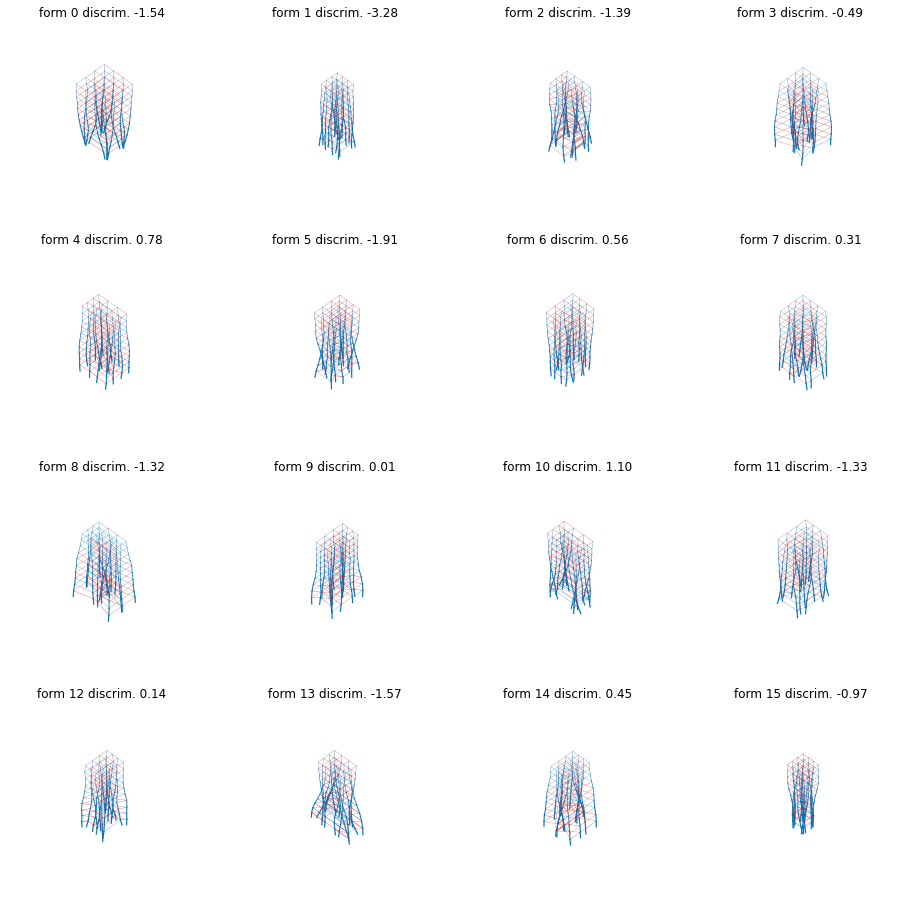

In [42]:
dis_output = discriminator.predict(np.concatenate([all_vectors[:16], all_labels[:16]],axis=-1))

check_forms([get_CEM_form(all_vectors_raw[i])[0] for i in range(16)],titles=['form %d discrim. %.2f'%(i,dis_output[i]) for i in range(16)],  figsize=16)

generate forms with input text

In [39]:
def text2form(t, num=16):
    # random input vector
    random_input=np.random.normal(size=(num, input_size_latent))
    # text vector
    label_input=input_text_encoder(t)[None,...][[0]*num]
    
    # input vector (i.e., concatenation of random and text vectors)
    gen_input=np.concatenate([random_input, label_input], axis=-1)
    
    # output vector (i.e., the CEM design parameters)
    gen_output = generator.predict(gen_input)
    # denormalize the output vector
    gen_output_denormalized=gen_output*all_vectors_std + all_vectors_mean
    
    # use the CEM design parameters to generate towers, and visualize them as 3D graphics
    check_forms([get_CEM_form(gen_output_denormalized[i])[0] for i in range(num)], figsize=16)

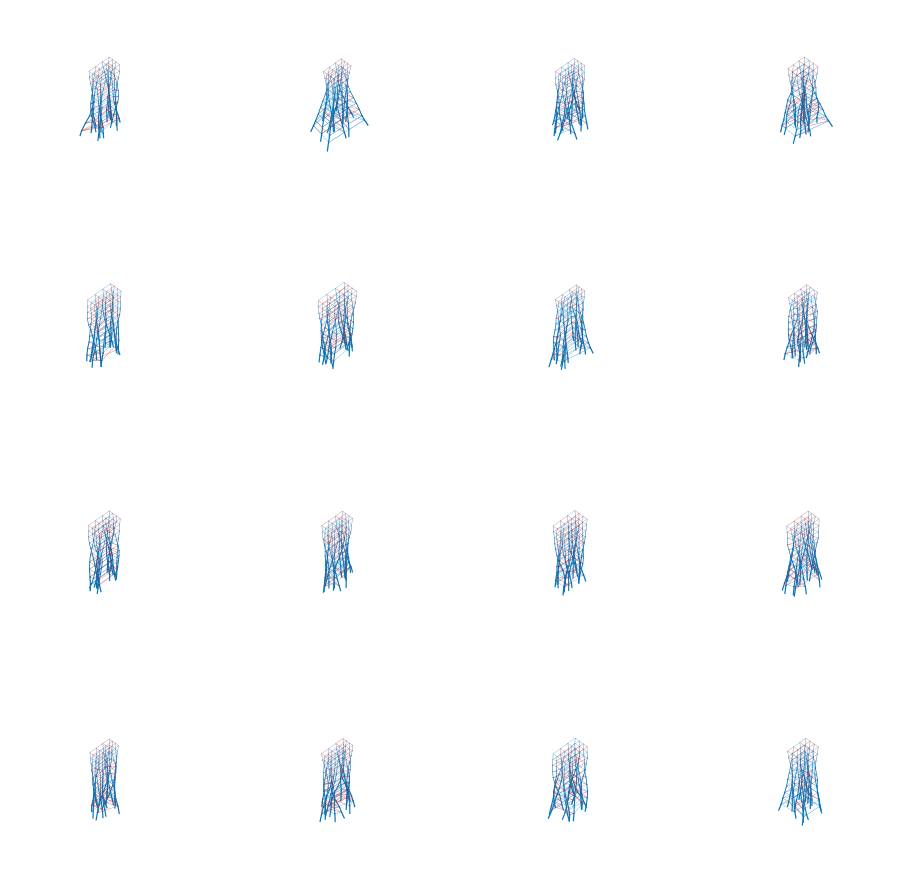

In [40]:
text2form("thin twisted")

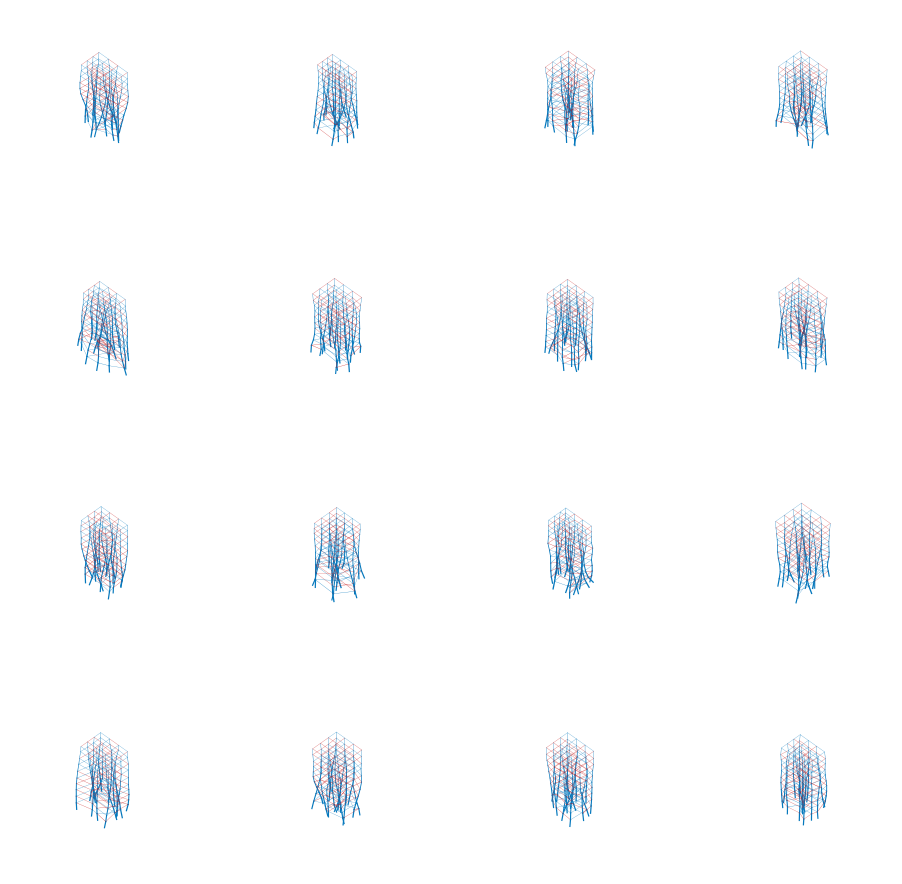

In [41]:
text2form("strong unbalanced")

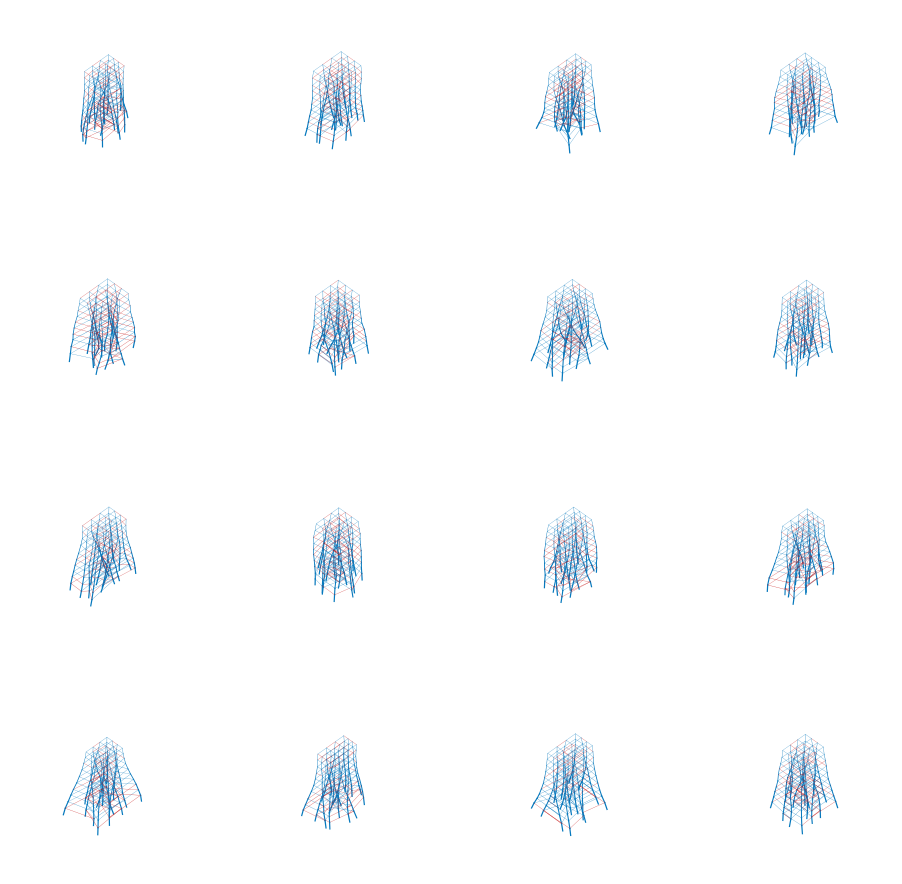

In [42]:
text2form("heavy strong")

show results for IASS paper

In [33]:
def generate_forms_from_text(input_text, num=4, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    print('processing',input_text,end='\r')
    
    random_input=np.random.normal(size=(num, input_size_latent))
    label_input=input_text_encoder(input_text)[None,...][[0]*num]
    
    gen_input=np.concatenate([random_input, label_input], axis=-1)
    
    # generate the vector
    gen_output = generator.predict(gen_input)
    dis_output = discriminator.predict(np.concatenate([gen_output, label_input],axis=-1))

    # denormalize the vector
    gen_output_denormalized=gen_output*all_vectors_std + all_vectors_mean
    
    return [get_CEM_form(gen_output_denormalized[i])[0] for i in range(num)]

In [34]:
def generate_forms_from_text_vector_only(input_text, num=4, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    print('processing',input_text,end='\r')
    
    random_input=np.random.normal(size=(num, input_size_latent))
    label_input=input_text_encoder(input_text)[None,...][[0]*num]
    
    gen_input=np.concatenate([random_input, label_input], axis=-1)
    
    # generate the vector
    gen_output = generator.predict(gen_input)

    # denormalize the vector
    gen_output_denormalized=gen_output*all_vectors_std + all_vectors_mean
    
    return gen_output_denormalized

In [35]:
my_texts=["thin twisted", "thin simple", "thick heavy", "thick simple balanced"]
my_seeds=[45,78,23,68]
num=16

In [68]:
all_generated_vectors=[generate_forms_from_text_vector_only(t, num, s) for t,s in zip(my_texts,my_seeds)]

In [69]:
for v, t in zip(all_generated_vectors, my_texts):
    fname='../output_IASS2022/%s.csv'%(t.replace(' ','-'))
    np.savetxt(fname, v, delimiter=",", fmt='%1.9f') # , fmt='%1.9f'

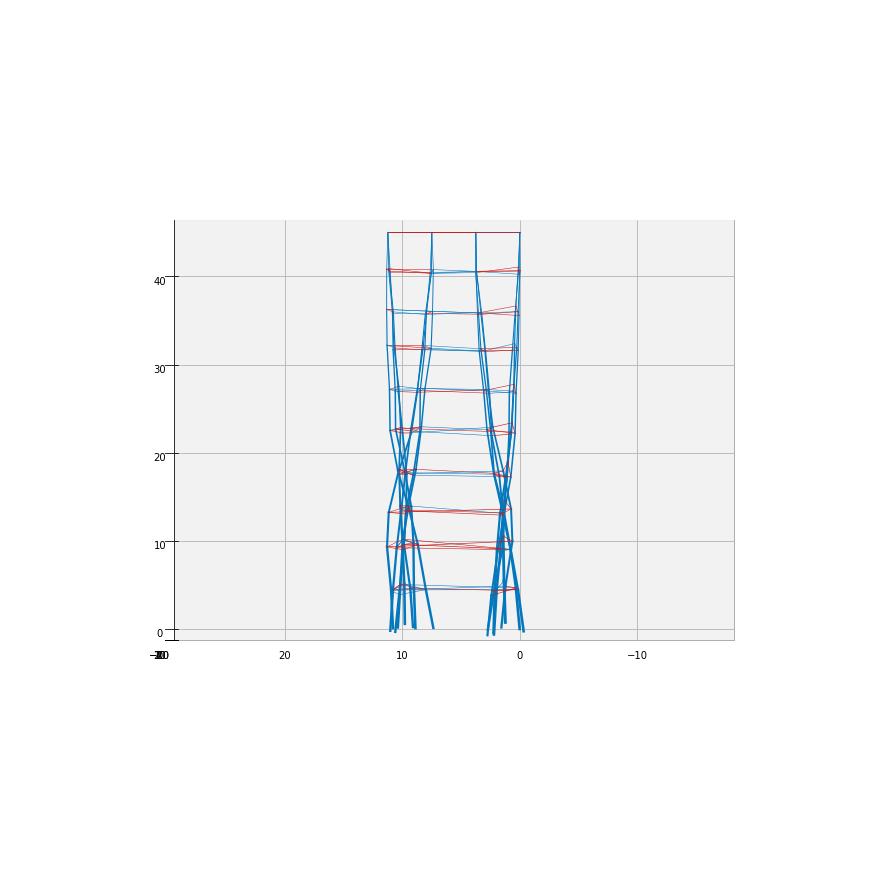

In [70]:
check_forms(get_CEM_form(all_generated_vectors[0][3])[0],axis='on', view='2D-XZ', rows=1,figsize=16)

In [66]:
# my_texts=["thin complex", "heavy complex architectural", "strong large"]
# num=8

In [73]:
my_forms=[generate_forms_from_text(t,num) for t in my_texts]

check_result = lambda x:check_forms(my_forms[x],rows=1,figsize=16,suptitle=my_texts[x])

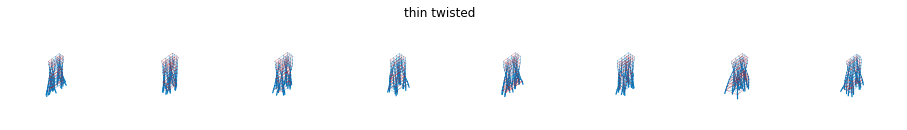

In [74]:
check_result(0)

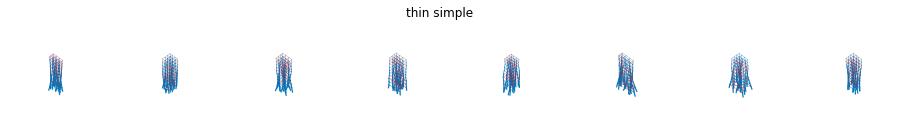

In [75]:
check_result(1)

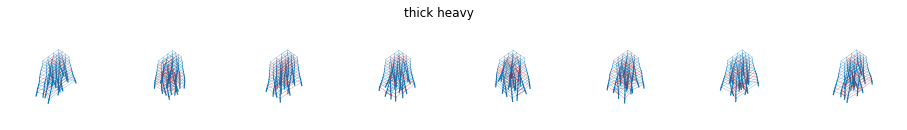

In [76]:
check_result(2)

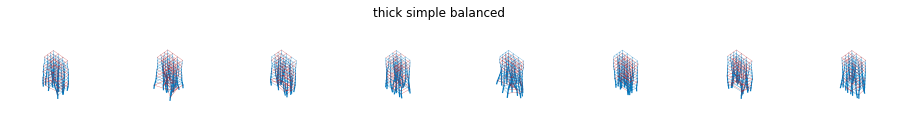

In [77]:
check_result(3)

In [78]:
for i in range(len(my_texts)):
    check_forms(my_forms[i],rows=1,suptitle=my_texts[i], figsize=16, fname='../output_IASS2022/%s_regenerate_%s_%d.svg'%(user_name, my_texts[i].replace(' ','-'),num))